### 1. 理论知识

1. 梯度是一个**向量**（**有大小，有方向**），它包含了多元函数在给定点处的**偏导数**。如 **f(z) = x + y**，的梯度为Δf = (1, 1)**（分别对x, y求偏导）**

2. 梯度的方向指向了**函数值增加最快**的方向，梯度的模长就是函数在该点的**最大变化率**

3. 如何理解梯度的方向，一定指向**函数值增加**的方向，以**f(z) = x + y** 为例， 求得梯度**Δf = (1, 1)**，即从(0, 0)点指向了(1, 1)的方向，自然可得函数值增加。而以**f(z) = -x - y** 求梯度得**Δf = (-1, -1)**，即从(0, 0)指向(-1, -1)的方向，会发现，往这个方向走时，x,y取值会越来越小，**（变成负数）**，代入到**f(z) = -x - y**中，发现f(z)的值，同样在越变越大。

4. 在机器学习中，梯度一般用于求最优化问题，即将损失函数朝着**梯度的反方向**迭代，即可求得参数即**梯度下降算法**。

### 2.数据准备

##### 2.1 导入数据集

In [1]:
# 导入模块
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np

# 处理数据集
ca_housing=fetch_california_housing()
X = pd.DataFrame(data=ca_housing.data, columns=ca_housing.feature_names)
y = pd.DataFrame(data=ca_housing.target, columns=["区平均售价"])

# 特征重命名
map_={
    'MedInc': '区收入中位数',
    'HouseAge': '区房屋年龄中位数',
    'AveRooms': '每户的平均房间数',
    'AveBedrms': '每户的平均卧室数',
    'Population': '区人口数',
    'AveOccup': '平每个家庭的成员数',
    'Latitude': '区组纬度',
    'Longitude': '区经度',
}
X=X.rename(columns=map_)
X

,区收入中位数,区房屋年龄中位数,每户的平均房间数,每户的平均卧室数,区人口数,平每个家庭的成员数,区组纬度,区经度
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


#### 2.2 数据处理

线性回归一般公式 y = ax + b, 假如有n列特征，得y = a1·x1 + a2·x2 + ... an·xn + b，**(矩阵形式：X·A + b =Y)**，此时可手动增加一列特征xn+1 = 1，线性回归公式则得 y = a1·x1 + a2·x2 + ... an·xn + b·xn+1，则 A=[a1,a2,...,an,b], **(化为矩阵形式：X·A = Y)**，求解得A(**最小二乘法、梯度下降法**)，则b = A[-1]

In [2]:
# 添加补充列
X_1=pd.concat([X,pd.DataFrame(data=[1]*len(X),columns=["补充"])],axis=1)

# 最后将X,y array化，方便后续计算，矩阵乘法@符号，和A.dot(B)形式都要求为array，否则只能用np.dot(A,B)
X_1=X_1.values
y=y.values

### 3. 算法实现

#### 3.1 最小二乘法 ~ 正规方程

**最小二乘法思想**：假设一元二次函数的损失函数：**J(a) = (1/2n) · sum( (axi-yi)^2 )** （1/2n中的2是为了求导后使得前面的系数为1），对损失函数求导，令导数 = 0 （凸函数可以获取极小值），从而求解可得系数 a。**矩阵形式则如下**：

1. 由最小二乘法：**Y = X · A**，可得损失函数**J(A) = (1/2n) · ( X·A − Y )^2 ，**  展开即得 **J(A) =(1/2n) · ( X·A − Y ).T · ( X·A − Y )**

2. 对损失函数J(A)求导，令其 = 0，解**正规方程**得：**X.T·X·A - X.T·Y = 0** ，解得：**A = (X.T·X)^-1 · X.T·Y**

3. 具体推导过程：https://blog.csdn.net/MoreAction_/article/details/106443383

4. 附加推导过程
https://blog.csdn.net/didiaopao/article/details/126483324?csdn_share_tail=%7B%22type%22%3A%22blog%22%2C%22rType%22%3A%22article%22%2C%22rId%22%3A%22126483324%22%2C%22source%22%3A%22didiaopao%22%7D

In [3]:
from sklearn.metrics import mean_squared_error as mse

# 最小二乘法~正规方程求解：核心公式！！！！！
A = np.linalg.inv(X_1.T@X_1)@X_1.T@y # np.linalg.inv 求矩阵的逆，但是假如矩阵不可逆？

# 损失函数写法1
loss = (1/2) * np.sum((np.dot(X_1,A)-y)**2) / X.shape[0]
print("Loss值：",loss)

# 损失函数写法2
error=np.dot(X_1,A)-y
cost = (1 / 2) * np.dot(error.T, error) / X.shape[0]
print("cost",cost)

# MSE均方误差
pred_y = np.dot(X_1,A)
print("MSE均方误差：",mse(pred_y,y))

Loss值： 0.2621604930923036
cost [[0.26216049]]
MSE均方误差： 0.5243209861846072


#### 3.2 梯度下降

**梯度下降思想**：以均方误差作为损失函数：**J(A) = (1/2n) · ( X·A − Y )^2 ，** ,（1/2n中的2是为了求导后使得前面的系数为1），此时A是自变量，X是常量，对A求梯度，可得ΔA ,A = A - ΔA（往梯度的反方向迭代时），损失函数可获取最小值，**ΔA = gradient = (1/n)·X.T·(X·A - Y)**

**注意！！一定要对数据进行归一化，统一量纲，不然梯度下降有很大概率无法收敛！！**

In [4]:
# 数据归一化！！！！非常重要！！！！
from sklearn.preprocessing import Normalizer
X_1=Normalizer().fit_transform(X_1)


# 设置迭代次数与下降速率
n_iterations = 1000
learning_rate = 0.01

# 设置随机初始 A
loss_his=[]
A = np.random.rand(X_1.shape[1], 1)
n = X_1.shape[0]

for _ in range(n_iterations):

    # 梯度求解：核心公式！！！！！
    gradients = (1/n)*X_1.T @ (X_1 @ A - y)
    
    # 参数迭代
    A = A - learning_rate * gradients
    
    # 求损失值
    loss=mse(X_1@A,y)
    loss_his.append(loss)

    

# MSE均方误差
pred_y = np.dot(X_1,A)
print("MSE均方误差：",mse(pred_y,y))

MSE均方误差： 1.3437802590818884


<Axes: >

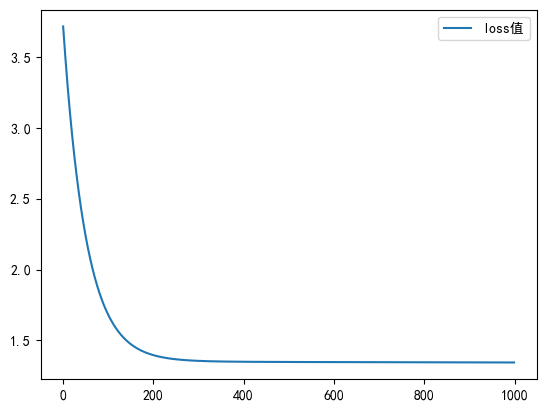

In [5]:
# 绘图设置
from matplotlib import rcParams
rcParams['font.family'] = 'SimHei'

pd.DataFrame(data=loss_his,columns=["loss值"]).plot()

### 4. 总结

1. 正规方程：**J(A) = 0 = X.T·X·A - X.T·Y**

2. 梯度：**ΔA = gradient = (1/n)·X.T·(X·A - Y)**

3. 由于 **最小二乘法** 与 **梯度下降** 的损失函数一致：**J(A) = (1/2n) · ( X·A − Y )^2 ，**

4. 所以对最小二乘法求导=0得到的正规方程 = 梯度*n

5. 尚未掌握：**损失函数求导**、**正规方程求解**、**损失函数求解梯度**，等数学推导
